In [1]:
%matplotlib inline
from consts import * 
from scipy import optimize
from scipy.integrate import ode
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
import re

## 电子枪相关计算
----
微波电子枪中，轴线上的纵向电场分布可以表示为

\begin{align}
  E(z,t,\phi_0)=E_0 \cos(kz)\sin(\omega t + \phi_0)
\end{align}

## 运动方程
---
以$\phi$为自变量，运动方程可表示为
\begin{align}
  \frac{dz}{d\phi} &= \frac{\lambda}{2 \pi} \beta \\
  \frac{d(\beta\gamma)}{d\phi} &= \frac{\lambda}{2 \pi} \frac{e E_z}{m_0 c^2}
\end{align}

其中，$\beta$、$\gamma$均可由$(\beta\gamma)$求得

\begin{align}
  \beta = \frac{(\beta\gamma)}{\sqrt{1+(\beta\gamma)^2}}, \gamma = \sqrt{1+(\beta\gamma)^2}
\end{align}


## 定义电场函数及其导数

In [7]:
ome=2*np.pi*2856e6
lam=2*np.pi*g_c/ome

def fun(E0,z,t,phi0,contract=1):
    'z -> m; t -> s; phi0 -> degree'
    return E0*np.cos(2*np.pi/lam*z/contract)*np.sin(ome*t+np.pi*phi0/180.)

def deriv(t,y,E0,phi0,m=1.5,contract=1):
    't -> phi/degree; y[0] -> z/m; y[1] -> bg/1'
    tt=t/ome # tt is real time
    if y[0]>lam/2*m*contract or y[0]<0:
        Ez=0
    else:      
        Ez=fun(E0,y[0],tt,phi0,contract)
    
    dydt=[0,0]
    dydt[0]=lam/2/np.pi*y[1]/np.sqrt(1+y[1]**2)
    dydt[1]=lam/2/np.pi*g_qe/g_me/g_c**2*Ez

    return dydt

def fun1(E0,z,t,phi0,contract=1):
    return E0*np.sin(2*np.pi/lam*z/contract)*np.sin(ome*t+np.pi*phi0/180.)

def deriv1(t,y,E0,phi0,m=1.5,contract=1):
    't -> phi/radian; y[0] -> z/m; y[1] -> bg'
    tt=t/ome # tt is real time
    if y[0]>lam/2*m*contract or y[0]<0:
        Ez=0
    else:      
        Ez=fun1(E0,y[0],tt,phi0,contract)
    
    dydt=[0,0]
    dydt[0]=lam/2/np.pi*y[1]/np.sqrt(1+y[1]**2)
    dydt[1]=lam/2/np.pi*g_qe/g_me/g_c**2*Ez

    return dydt

## 检验电场函数，分别以$z$和$t$为自变量

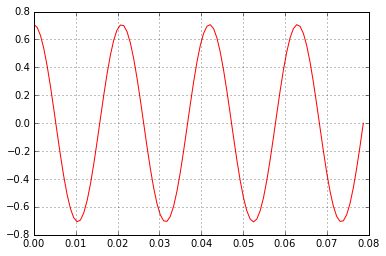

In [3]:
x=np.linspace(0,lam*0.75,100)
f=lambda z: fun(1.0,z,0,45,0.2)
ff=f

plt.plot(x,f(x),'r-')
plt.grid()
plt.show()

x=np.linspace(0,360,360)
f=lambda t: fun(1.0,0,t/ome/360.*2*np.pi,90)

plt.plot(x,f(x),'r-')
plt.grid()
plt.show()

## 计算$\gamma$，一个例子 

1.00000058708


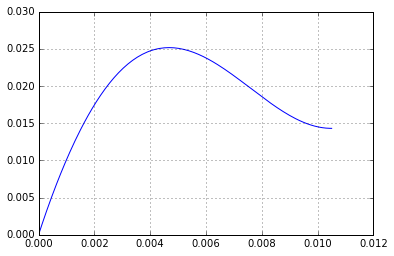

In [20]:
g0=0.3/0.511e6+1
bg0=np.sqrt(g0**2-1)
print g0
y0,t0=[0,bg0],0

m,c=0.5,0.4
t1,dt=2*np.pi,np.pi/180

r=ode(deriv).set_integrator('dopri5')
r.set_initial_value(y0,t0).set_f_params(12e6,100,m,c)

sol=[]
while r.successful() and r.t<t1 and r.y[0]<m*c*lam/2:
    r.integrate(r.t+dt)
    sol.append([r.t*180./np.pi, r.y[0], np.sqrt(r.y[1]**2+1)])
sol=np.array(sol)

plt.plot(sol[:,1],sol[:,2]*0.511-0.511)
plt.grid()
plt.show()
#fname='solution.dat'
#np.savetxt(fname,sol,fmt='%12.4E')

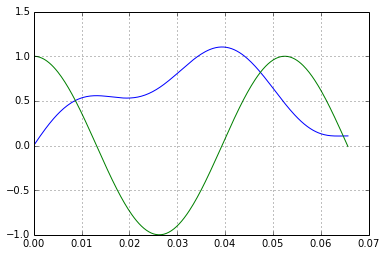

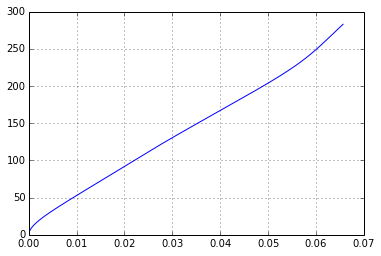

In [9]:
f=lambda z: fun(1.0,z,0,90,c)

plt.plot(sol[:,1],sol[:,2]*0.511-0.511,sol[:,1],f(sol[:,1]))
plt.grid()
plt.show()
plt.plot(sol[:,1],sol[:,0])
plt.grid()
plt.show()

## 设计首腔长度

In [4]:
c=1
E_0=60
phi_0=120
ss=[]
for i in np.arange(1): 
    
    phi_0=60+i*10
    
    g0=0.2/0.511e6+1
    bg0=np.sqrt(g0**2-1)

    y0,t0=[0,bg0],0

    m=0.5
    
    t1,dt=2*np.pi,np.pi/180

    r=ode(deriv).set_integrator('dopri5')
    r.set_initial_value(y0,t0).set_f_params(E_0*1e6,phi_0,m,c)

    sol0=[]
    while r.successful() and r.t<t1 and r.y[0]<m*c*lam/2:
        r.integrate(r.t+dt)
        sol0.append([r.t*180./np.pi, r.y[0], np.sqrt(r.y[1]**2+1)])
    sol=np.array(sol0)
    dd=r.t*180./np.pi
    ss.append([phi_0,r.y[1],r.t*180./np.pi+phi_0-360])
    #continue
    #break
    if np.abs(dd-90)>0.01:
        c=c*90./dd
    else:
        break
t_1,bg_1,z_1=r.t*180./np.pi,r.y[1],m*c*lam/2

print 'c = ',c
print t_1,bg_1,z_1

c =  0.756302521008
119.0 2.41603583612 0.0198471456377


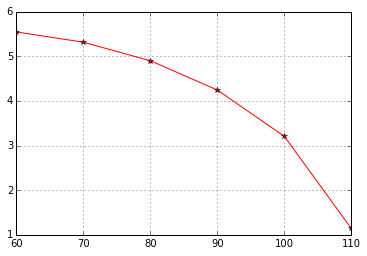

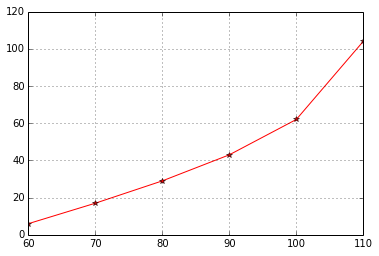

In [46]:
ss=np.array(ss)
plt.plot(ss[:,0],ss[:,1],'r*-')
plt.grid()
plt.show()
plt.plot(ss[:,0],ss[:,2],'r*-')
plt.grid()
plt.show()

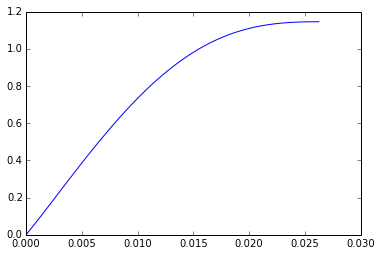

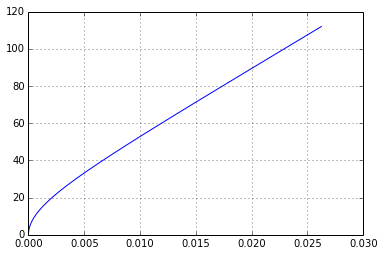

In [11]:
plt.plot(sol[:,1],sol[:,2]*0.511-0.511)
plt.show()
plt.plot(sol[:,1],sol[:,0])
plt.grid()
plt.show()

## 设计次腔长度

In [406]:
c=0.6
for i in np.arange(100): 
    #print i

    y0,t0=[0,bg_1],0

    m=1
    
    t1,dt=2*np.pi,np.pi/180

    r=ode(deriv1).set_integrator('dopri5')
    r.set_initial_value(y0,t0).set_f_params(40e6,phi_0-180+t_1,m,c)

    #sol=[]
    while r.successful() and r.t<t1 and r.y[0]<m*c*lam/2:
        r.integrate(r.t+dt)
        sol0.append([r.t*180./np.pi, z_1+r.y[0], np.sqrt(r.y[1]**2+1)])
    sol=np.array(sol0)
    dd=r.t*180./np.pi
    break
    if np.abs(dd-51)>0.01:
        c=c*51./dd
    else:
        break
t_2,bg_2,z_2=r.t*180./np.pi,r.y[1],m*c*lam/2+z_1

print 'c = ',c
print t_2,bg_2,z_2

c =  0.6
115.0 3.15079990455 0.0524846740196


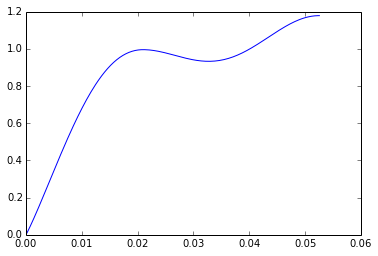

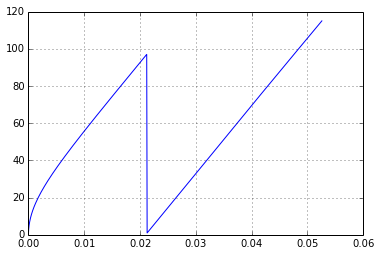

In [407]:
plt.plot(sol[:,1],sol[:,2]*0.511-0.511)
plt.show()
plt.plot(sol[:,1],sol[:,0])
plt.grid()
plt.show()

In [408]:
c=1.437
for i in np.arange(100): 
    #print i

    y0,t0=[0,bg_2],0

    m=1
    
    t1,dt=2*np.pi,np.pi/180

    r=ode(deriv1).set_integrator('dopri5')
    r.set_initial_value(y0,t0).set_f_params(40e6,phi_0+t_1+t_2,m,c)

    #sol=[]
    while r.successful() and r.t<t1 and r.y[0]<m*c*lam/2:
        r.integrate(r.t+dt)
        sol0.append([r.t*180./np.pi, z_2+r.y[0], np.sqrt(r.y[1]**2+1)])
    sol=np.array(sol0)
    dd=r.t*180./np.pi
    #break
    if np.abs(dd-272)>0.01:
        c=c*272./dd
    else:
        break
t_3,bg_3,z_3=r.t*180./np.pi,r.y[1],m*c*lam/2+z_2

print 'c = ',c
print t_3,bg_3,z_3

c =  1.43173626374
272.0 4.20505716856 0.127628885104


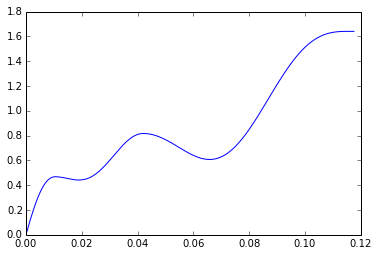

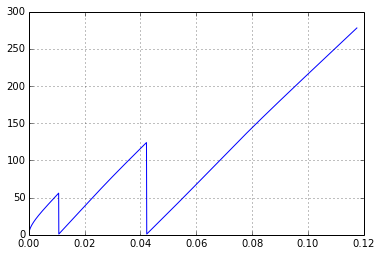

In [381]:
plt.plot(sol[:,1],sol[:,2]*0.511-0.511)
plt.show()
plt.plot(sol[:,1],sol[:,0])
plt.grid()
plt.show()

## 给定纵向电场分布，计算不同相位发射的电子的能量增益
---
给定纵向分布，即$E_z(z)$，则电场为

\begin{equation}
  E(z,t)=E_z(z)\sin(\omega t)
\end{equation}



In [8]:
ome=2*np.pi*2856e6
lam=2*np.pi*g_c/ome

def fun(E0,z,t,phi0):
    'z -> m; t -> s; phi0 -> radian'
    return E0*np.cos(2*np.pi/lam*z)*np.sin(ome*t+phi0)

def deriv(t,y,E0,phi0,func):
    't -> phase/radian; y[0] -> z/m; y[1] -> bg/1'
    time=t/ome # tt is real time
    
    Ez=func(E0,y[0],time,phi0)
    #print y[0],Ez
    
    dydt=[0,0]
    dydt[0]=lam/2/np.pi*y[1]/np.sqrt(1+y[1]**2)
    dydt[1]=lam/2/np.pi*g_qe/g_me/g_c**2*Ez

    return dydt

## 给定电场分布下，不同相位发射电子获得的能量

In [9]:
workdir='F:\\CAEP\\Egun-new\\field-maps'
workdir='F:\\Workshop\\THz-FEL\\8ps\\Transport\\Chicane\\field-maps'
os.chdir(workdir)

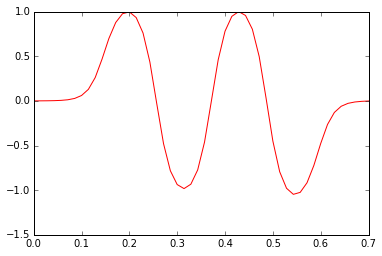

In [10]:
ome=2*np.pi*1300e6
lam=2*np.pi*g_c/ome
data=np.loadtxt('4-Cell-1.dat')
fz=interp1d(data[:,0],data[:,1]/np.max(data[:,1]),bounds_error=False,fill_value=0)

ff=lambda E0,zz,tt,phi0:E0*fz(zz)*np.sin(ome*tt+phi0) ## z->m; t->s; phi0->radian

zz=np.linspace(0,70e-2)
plt.plot(zz,ff(1,zz,0,90/180.*np.pi),'r-')
plt.show()

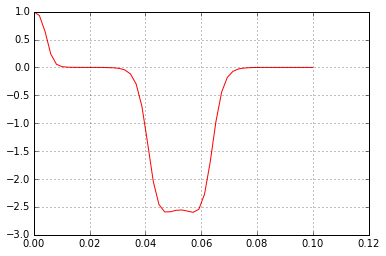

In [256]:
data1=np.loadtxt('0.15_.dat')
fz1=interp1d(data1[:,0],data1[:,1]/np.max(data1[:,1]),bounds_error=False,fill_value=0)

data2=np.loadtxt('0.40_1.dat')
fz2=interp1d(data2[:,0]+5.25e-2*0.5,data2[:,1]/np.max(data2[:,1]),bounds_error=False,fill_value=0)

fz=lambda z:fz1(z)+fz2(z)

#ff=lambda E0,zz,tt,phi0:E0*fz(zz)*np.sin(ome*tt+phi0) ## z->m; t->s; phi0->radian
ff=lambda E0,zz,tt,phi0,E1,phi1:E0*fz1(zz)*np.sin(ome*tt+phi0)+E1*fz2(zz)*np.sin(ome*tt+phi0+np.pi+phi1) ## z->m; t->s; phi0->radian

zz=np.linspace(0,10e-2)
plt.plot(zz,ff(1,zz,0,90/180.*np.pi,3,30/180.*np.pi),'r-')
plt.grid()
plt.show()

In [13]:
g0=0.3/0.511e6+1
bg0=np.sqrt(g0**2-1)

y0,t0=[1e-6,bg0],0

t1,dt=10*np.pi,np.pi/180
#t1=10*dt

r=ode(deriv).set_integrator('dopri5')
r.set_initial_value(y0,t0).set_f_params(12e6,90/180.*np.pi,12e6,0,ff)

sol=[]
sol.append([t0,y0[0],g0])
while r.successful() and r.t<t1 and r.y[0]<10e-2:# and r.y[1]>0:
    r.integrate(r.t+dt)
    sol.append([r.t*180./np.pi, r.y[0], np.sqrt(r.y[1]**2+1)]) ## [phase,z,gamma
    #break
sol=np.array(sol)
#print sol
plt.plot(sol[:,0],sol[:,2]*0.511-0.511)
plt.grid()
plt.show()

TypeError: 'float' object has no attribute '__getitem__'

In [25]:
sol=[]
for i in np.arange(31):
    phi_0=0+i*12
    
    g0=0.32e6/0.511e6+1
    bg0=np.sqrt(g0**2-1)
    
    y0,t0=[1e-6,bg0],0
    
    t1,dt=10*np.pi,np.pi/60
    #t1=10*dt
    
    r=ode(deriv).set_integrator('dopri5')
    r.set_initial_value(y0,t0).set_f_params(16e6,phi_0/180.*np.pi,ff)
    
    while r.successful() and r.t<t1 and r.y[0]<70e-2:# and r.y[1]>0:
        r.integrate(r.t+dt)
        #sol.append([r.t*180./np.pi, r.y[0], np.sqrt(r.y[1]**2+1)]) ## [phase,z,gamma
        #break
    if r.y[1]>0:
        sol.append([phi_0, np.sqrt(r.y[1]**2+1)])
sol=np.array(sol)
#print sol

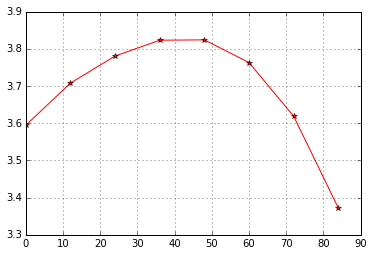

In [27]:
plt.plot(sol[:8,0],sol[:8,1]*0.511-0.511,'r-*')
#plt.plot(np.arange(60,121),gauss(np.arange(60,121),90,16,6),'b-')
plt.grid()
plt.show()

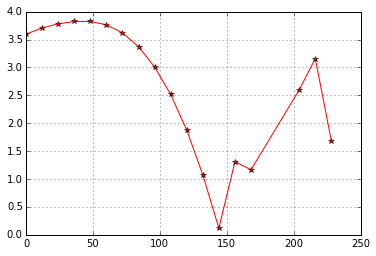

In [29]:
#gauss=lambda x,mu,sigma,scale=1:scale/np.sqrt(2*np.pi)/sigma*np.exp(-(x-mu)**2/2.0/sigma**2)

plt.plot(sol[0:18,0],sol[0:18,1]*0.511-0.511,'r-*')
#plt.plot(np.arange(60,121),gauss(np.arange(60,121),90,16,6),'b-')
plt.grid()
plt.show()
#fname='l_0.40_0.25.dat'
#np.savetxt(fname,sol,fmt='%12.4E')

## 计算不同腔长和加速电场下，电子的临界发射相位

In [ ]:
ome=2*np.pi*2856e6
lam=2*np.pi*g_c/ome

def fun(E0,z,t,phi0,contract=1):
    'z -> m; t -> s; phi0 -> degree'
    return E0*np.cos(2*np.pi/lam*z/contract)*np.sin(ome*t+np.pi*phi0/180.)

def deriv(t,y,E0,phi0,m=1.5,contract=1):
    't -> phi/degree; y[0] -> z/m; y[1] -> bg/1'
    tt=t/ome # tt is real time
    if y[0]>lam/2*m*contract or y[0]<0:
        Ez=0
    else:      
        Ez=fun(E0,y[0],tt,phi0,contract)
    
    dydt=[0,0]
    dydt[0]=lam/2/np.pi*y[1]/np.sqrt(1+y[1]**2)
    dydt[1]=lam/2/np.pi*g_qe/g_me/g_c**2*Ez

    return dydt

In [141]:
def critical_phase(E_0=60,c=1,m=0.5):    
    
    for i in np.arange(180): 
        
        phi_0=i*1
        
        g0=0.2/0.511e6+1
        bg0=np.sqrt(g0**2-1)
    
        y0,t0=[0,bg0],0
        t1,dt=2*np.pi,np.pi/180
    
        r=ode(deriv).set_integrator('dopri5')
        r.set_initial_value(y0,t0).set_f_params(E_0*1e6,phi_0,m,c)
    
        while r.successful() and r.t<t1 and r.y[1]>0:
            r.integrate(r.t+dt)
        if r.y[1]<0:
            phi_c=phi_0
            break
    return phi_c

In [142]:
print critical_phase()

119


In [146]:
r=[]
for i in np.arange(1,11):
    print '#'+`i`
    c=i*0.1
    for j in np.arange(1,15):
        E=j*5
        p=critical_phase(E,c)
        print '%12.2f  %12.0f  %12.0f' % (c,E,p)
        #r.append([c,E,p])
    print '\n\n'

#1
        0.10             5           121
        0.10            10           133
        0.10            15           139
        0.10            20           143
        0.10            25           146
        0.10            30           148
        0.10            35           150
        0.10            40           151
        0.10            45           152
        0.10            50           153
        0.10            55           154
        0.10            60           155
        0.10            65           155
        0.10            70           156



#2
        0.20             5           104
        0.20            10           120
        0.20            15           128
        0.20            20           133
        0.20            25           137
        0.20            30           139
        0.20            35           141
        0.20            40           143
        0.20            45           144
        0.20            50           146
       